In [166]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [167]:
import numpy as np
import pandas as pd

In [168]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [169]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import datetime
from flask import Flask, jsonify, request
from werkzeug.wrappers import Request, Response


In [170]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [171]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [172]:
# We can view all of the classes(tables) that automap found
Base.classes.keys()

['measurement', 'station']

In [173]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)

In [174]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [175]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [176]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [177]:
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [178]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [179]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [180]:
session = Session(engine)

In [181]:
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date[0])

2017-08-23


# Exploratory Climate Analysis

The date a year ago from the last data point is 2016-08-23


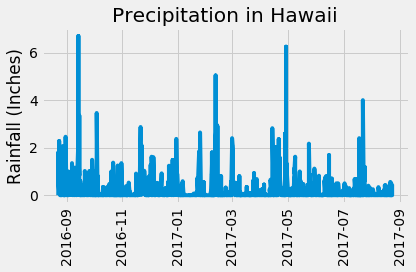

<Figure size 432x288 with 0 Axes>

In [182]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f'The date a year ago from the last data point is {year_ago}')

# Perform a query to retrieve the data and precipitation scores
date_prcp_query = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >='2016-08-23', Measurement.date <='2017-08-23').\
order_by(Measurement.date).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
#date_prcp_df = pd.read_sql(date_prcp_query, engine, index_col='date').dropna()
date_prcp_df = pd.read_sql(date_prcp_query, engine).dropna()
date_prcp_df.head(5)

# Sort the dataframe by date
date_prcp_df = date_prcp_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
date_prcp_df['date']  = pd.to_datetime(date_prcp_df['date'])
plt.plot(date_prcp_df['date'], date_prcp_df['prcp'])
plt.title("Precipitation in Hawaii")
plt.xlabel('')
plt.ylabel('Rainfall (Inches)')
plt.xticks(rotation='90')
plt.tight_layout()
plt.show()

plt.savefig("Images/precipation_over_year")


In [183]:
# Use Pandas to calcualte the summary statistics for the precipitation data
date_prcp_df.describe()


,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [184]:
# Design a query to show how many stations are available in this dataset?
station_boolean = session.query(Measurement.station).distinct().count()== session.query(Station.station).distinct().count()
if station_boolean:
    num_station = session.query(Measurement.station).distinct().count()
    print(f'The number of stations = {num_station}')
else:
    print('your database is not NSYNC')

The number of stations = 9


In [185]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
desc_observ = engine.execute('select station, count(station) from measurement group by station order by count(station) desc').fetchall()
desc_observ

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [186]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp_data = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == "USC00519281")
print(temp_data[0])

(54.0, 85.0, 71.66378066378067)


In [187]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result_temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date>year_ago).\
                filter(Measurement.station == "USC00519281")
result_temp_df = pd.DataFrame(result_temp[:],columns=['Date','TempObs'])
result_temp_df.head()

,Date,TempObs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


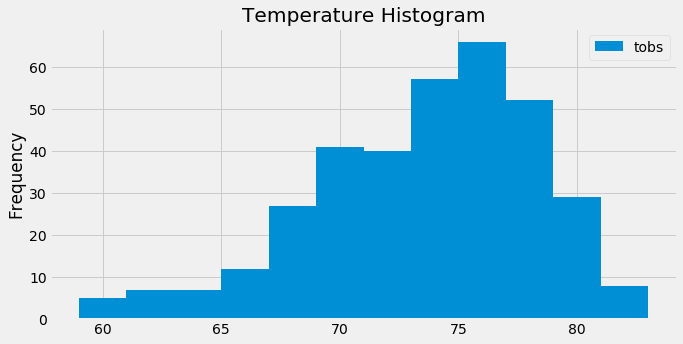

In [188]:
plt.figure(figsize=(10,5))
plt.hist(result_temp_df["TempObs"], bins=12, label='tobs')
plt.ylabel("Frequency")
plt.title("Temperature Histogram")
plt.legend()
plt.savefig("Images/Temperature_Histogram.png")
plt.show()

In [189]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [190]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2017-07-23','2017-08-05')
print(trip_temp)

[(72.0, 78.88157894736842, 84.0)]


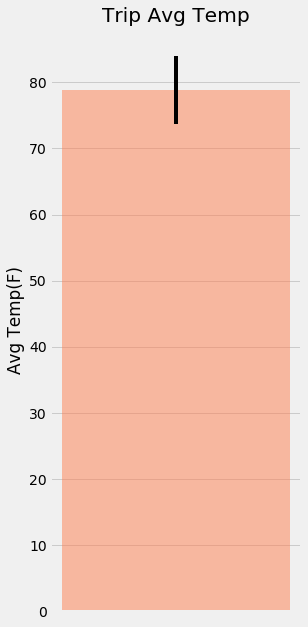

In [191]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(4,10))
plt.bar(1, trip_temp[0][1], color='coral', alpha=0.5, yerr=trip_temp[0][2]-trip_temp[0][1])
plt.title("Trip Avg Temp")
plt.xticks([])
plt.ylabel("Avg Temp(F)")
plt.savefig("Images/Trig_Avg_Temp_ErrBar.png")

In [192]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
Rainfall = func.avg(Measurement.prcp).label("Rainfall")
ly_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,Station.elevation, \
                            func.avg(Measurement.prcp).label("Rainfall")).\
                filter(Measurement.station == Station.station).filter(Measurement.date >= '2011-02-28').\
                filter(Measurement.date <= '2011-03-05').group_by(Measurement.station).order_by(Rainfall.desc())


index = 0
for rf in ly_rainfall:
    print(ly_rainfall[index])
    index = index + 1


('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.5825)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.392)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.37166666666666665)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.365)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.24166666666666667)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.24)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.22999999999999998)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.126)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)


## Step 2 CLIMATE APP

In [193]:
app = Flask(__name__)

In [194]:
# We create the home page using HTML.¶
# This page lists all available api routes.

In [195]:
@app.route("/")

def welcome():
   
    return (
        "<h1> Hawaii Precipitation and Weather Data</h1>"
        
        "<h3>Pick from the available routes below:</h3>"
        
        "Precipiation from 2016-08-23 to 2017-08-23.<br/>"
        "<a target='_blank' href='http://localhost:9000/api/v1.0/precipitation'>Precipitation Data</a><br/><br/>"
        
        "A list of all the weather stations in Hawaii.<br/>"
        "<a target='_blank'href= 'http://localhost:9000/api/v1.0/stations'>Weather Stations Data</a><br/><br/>"
        
        "The Temperature Observations (tobs) from 2016-08-23 to 2017-08-23.<br/>"
        "<a target='_blank' href='http://localhost:9000/api/v1.0/tobs'>Temperature Observations Data</a><br/><br/>"
        
        "Type in a single date (i.e., 2017-02-24) to see the min, max and avg temperature since that date.<br/>"
        "<form action='http://localhost:9000/api/v1.0/temp/' method='get'><input name='start' id='start' value='' placeholder='yyyy-mm-dd' ><div><button>Enter</button></div></form>"
        
        "Type in the start and end dates (i.e., 2016-08-23 and 2017-08-23) to see the min, max and avg temperature for that range.<br/>"
        "<form action='http://localhost:9000/api/v1.0/temp-range/' method='get'> Start Date <input name='start' id='start' value='' placeholder='yyyy-mm-dd'>End Date <input name='end' id='end' value='' placeholder='yyyy-mm-dd'><div><button>Enter</button></div></form>"
        
        "<img src='http://www.kauai.com/blog/wp-content/uploads/2011/10/kauai-rainbow.jpg'>"
    )

In [196]:
begin_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

@app.route("/api/v1.0/precipitation")

def precipitation():

    # Retrieve the last 12 months of precipitation data
    results = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > begin_date).\
                        order_by(Measurement.date).all()

    # Create a dictionary from the row data and append to a list of for the precipitation data
    precipitation_data = []
    for prcp_data in results:
        prcp_data_dict = {}
        prcp_data_dict["Date"] = prcp_data.date
        prcp_data_dict["Precipitation"] = prcp_data.prcp
        precipitation_data.append(prcp_data_dict)
        

    return jsonify(precipitation_data)

In [197]:
@app.route("/api/v1.0/stations")

def stations():
    
    # Query all the stations
    results = session.query(Station).all()

    # Create a dictionary from the row data and append to a list of all_stations.
    all_stations = []
    for stations in results:
        stations_dict = {}
        stations_dict["Station"] = stations.station
        stations_dict["Station Name"] = stations.name
        stations_dict["Latitude"] = stations.latitude
        stations_dict["Longitude"] = stations.longitude
        stations_dict["Elevation"] = stations.elevation
        all_stations.append(stations_dict)
    
    return jsonify(all_stations)

In [198]:
@app.route("/api/v1.0/tobs")

def tobs():
    
    # Query all the stations and for the given date. 
    results = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
                    group_by(Measurement.date).\
                    filter(Measurement.date > begin_date).\
                    order_by(Measurement.station).all()
                    
    # Create a dictionary from the row data and append to a list of for the temperature data.
    temp_data = []
    for tobs_data in results:
        tobs_data_dict = {}
        tobs_data_dict["Station"] = tobs_data.station
        tobs_data_dict["Date"] = tobs_data.date
        tobs_data_dict["Temperature"] = tobs_data.tobs
        temp_data.append(tobs_data_dict)
    
    return jsonify(temp_data)


In [199]:
@app.route("/api/v1.0/temp/", methods=['get'])

def start_stats(start=None):
    
    start = request.args.get('start')
    
    # Query all the stations and for the given date. 
    results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.date >= start).all()

    # Create a dictionary from the row data and append to a list of for the temperature data.
    temp_stats = []
    
    for Tmin, Tmax, Tavg in results:
        temp_stats_dict = {}
        temp_stats_dict["Minimum Temp"] = Tmin
        temp_stats_dict["Maximum Temp"] = Tmax
        temp_stats_dict["Average Temp"] = Tavg
        temp_stats.append(temp_stats_dict)
    
    return jsonify(temp_stats)


In [200]:
@app.route("/api/v1.0/temp-range/", methods=['get'])
def calc_stats(start=None, end=None):
    
    start = request.args.get('start')
    end   = request.args.get('end') 
    
    # Query all the stations and for the given range of dates. 
    results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.date >= start).filter(Measurement.date <= end).all()

    # Create a dictionary from the row data and append to a list of for the temperature data.
    begin_end_stats = []
    
    for Tmin, Tmax, Tavg in results:
        begin_end_stats_dict = {}
        begin_end_stats_dict["Minimum Temp"] = Tmin
        begin_end_stats_dict["Maximum Temp"] = Tmax
        begin_end_stats_dict["Average Temp"] = Tavg
        begin_end_stats_dict['start']=start
        begin_end_stats_dict['end']=end
        begin_end_stats.append(begin_end_stats_dict)
    
    return jsonify(begin_end_stats)

In [ ]:
if __name__ == '__main__':
    from werkzeug.serving import run_simple
    run_simple('localhost', 9000, app)

# Optional Challenge Assignment

In [202]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [203]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-07-23'
end_date ='2017-08-05'
# Use the start and end date to create a range of dates

dates = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()

# List comprehension to get the elements in the tuple from the dates query 
trip_dates = [x[0] for x in dates]

# Stip off the year and save a list of %m-%d strings with another list comprehension 
trip_dates_stripped= [x[5:] for x in trip_dates]

# Find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]


#daily_normals = [session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()]
    
# Loop through the list of %m-%d strings and calculate the normals for each date    
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
print("Aggregate Daily Normals for 07-23 to 08-05")
daily_normals

Aggregate Daily Normals for 07-23 to 08-05


[(70.0, 76.20370370370371, 84.0),
 (69.0, 76.55555555555556, 81.0),
 (67.0, 76.89090909090909, 84.0),
 (71.0, 76.4423076923077, 86.0),
 (68.0, 76.58181818181818, 83.0),
 (69.0, 76.46428571428571, 82.0),
 (69.0, 76.47058823529412, 83.0),
 (69.0, 77.35185185185185, 84.0),
 (72.0, 77.03571428571429, 83.0),
 (67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0)]

In [204]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


# Create a dataframe from the previous query 
daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])

# Add trip_dates to Pandas DataFrame
daily_normals_df['date']= trip_dates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

# Set index to date
daily_normals_df.set_index('date',inplace=True)

daily_normals_df

,tmin,tavg,tmax
date,,,
2017-07-23,70.0,76.203704,84.0
2017-07-24,69.0,76.555556,81.0
2017-07-25,67.0,76.890909,84.0
2017-07-26,71.0,76.442308,86.0
2017-07-27,68.0,76.581818,83.0
2017-07-28,69.0,76.464286,82.0
2017-07-29,69.0,76.470588,83.0
2017-07-30,69.0,77.351852,84.0
2017-07-31,72.0,77.035714,83.0


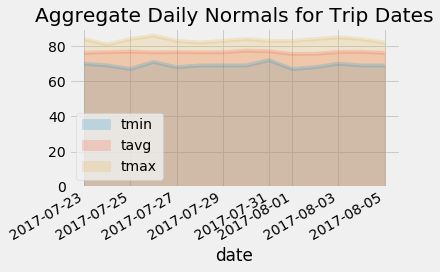

In [205]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("Images/DailyNormals.png")
plt.show()